In [3]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
import os
from PIL import Image
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [4]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YOLOv1, self).__init__()
        self.S, self.B, self.C = S, B, C

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # [B, 64, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 64, 112, 112]

            nn.Conv2d(64, 192, kernel_size=3, padding=1),          # [B, 192, 112, 112]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 192, 56, 56]

            nn.Conv2d(192, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),         # [B, 256, 56, 56]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),         # [B, 512, 56, 56]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 512, 28, 28]

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 1024, 14, 14]

            # ✅ Force output to [B, 1024, 7, 7]
            nn.AdaptiveAvgPool2d((self.S, self.S)),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # [B, 1024 * 7 * 7]
            nn.Linear(1024 * self.S * self.S, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5)),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)
    


In [8]:
class IOULoss(nn.Module):
    def __init__(self, S=7, B=2, C=20, lambda_coord=5, lambda_noobj=0.5):
        super(IOULoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")  # reduction="sum" → original YOLO style
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord       
        self.lambda_noobj = lambda_noobj

    def compute_iou(self, box1, box2):
        # box = [..., 4] => (x, y, w, h)
        b1_x1 = box1[..., 0] - box1[..., 2] / 2
        b1_y1 = box1[..., 1] - box1[..., 3] / 2
        b1_x2 = box1[..., 0] + box1[..., 2] / 2
        b1_y2 = box1[..., 1] + box1[..., 3] / 2

        b2_x1 = box2[..., 0] - box2[..., 2] / 2
        b2_y1 = box2[..., 1] - box2[..., 3] / 2
        b2_x2 = box2[..., 0] + box2[..., 2] / 2
        b2_y2 = box2[..., 1] + box2[..., 3] / 2

        inter_x1 = torch.max(b1_x1, b2_x1)
        inter_y1 = torch.max(b1_y1, b2_y1)
        inter_x2 = torch.min(b1_x2, b2_x2)
        inter_y2 = torch.min(b1_y2, b2_y2)
        inter_area = torch.clamp(inter_x2 - inter_x1, 0) * torch.clamp(inter_y2 - inter_y1, 0)

        area1 = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        area2 = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

        union = area1 + area2 - inter_area + 1e-6
        return inter_area / union
    def forward(self, predictions, target):
        print(f"calling iou loss fwd with pred shape {predictions.shape} \n and target shape {target.shape}")
        N = predictions.shape[0]
        predictions = predictions.reshape(N, self.S, self.S, self.C + self.B * 5)

        iou_box1 = self.compute_iou(predictions[..., 21:25], target[..., 21:25])
        iou_box2 = self.compute_iou(predictions[..., 26:30], target[..., 21:25])  # compare both to ground truth box

        iou_both = torch.stack([iou_box1, iou_box2], dim=0)
        best_box = torch.argmax(iou_both, dim=0).unsqueeze(-1).float()  # [N, S, S, 1]

        exists_object = target[..., 20].unsqueeze(-1)

        box_predictions = exists_object * (
            best_box * predictions[..., 26:30] +
            (1 - best_box) * predictions[..., 21:25]
        )
        box_targets = exists_object * target[..., 21:25]

        # box_loss = self.mse(box_predictions[..., :2], box_targets[..., :2]) + \
        #         self.mse(torch.sqrt(box_predictions[..., 2:]), torch.sqrt(box_targets[..., 2:] + 1e-6))
        box_loss = self.mse(box_predictions[..., :2], box_targets[..., :2]) + \
                self.mse(torch.sqrt(torch.clamp(box_predictions[..., 2:], min=1e-6)),
                            torch.sqrt(torch.clamp(box_targets[..., 2:], min=1e-6)))

        print(f"box loss: {box_loss}")
        # object loss
        object_loss = self.mse(
            exists_object * (
                best_box * predictions[..., 25:26] +
                (1 - best_box) * predictions[..., 20:21]
            ),
            exists_object * target[..., 20:21]
        )
        print(f"object loss: {object_loss}")

        # no-object loss
        no_object_loss = self.mse(
            (1 - exists_object) * predictions[..., 20:21], torch.zeros_like(predictions[..., 20:21])
        ) + self.mse(
            (1 - exists_object) * predictions[..., 25:26], torch.zeros_like(predictions[..., 25:26])
        )

        print(f"no-object loss: {no_object_loss}")
        # class loss
        class_loss = self.mse(
            exists_object * predictions[..., :self.C],
            exists_object * target[..., :self.C]
        )
        print(f"class loss: {class_loss}")
        print(f"BEFORE LOSS CALC: lambda coord = {self.lambda_coord}\n box loss={box_loss}\n object loss={object_loss}")
        print(f"print lamdba_noobj={self.lambda_noobj}\n no obj loss={no_object_loss} class_loss={class_loss}")
        loss = (
            self.lambda_coord * box_loss +
            object_loss +
            self.lambda_noobj * no_object_loss +
            class_loss
        )
        print(f"N: {N}")
        print(f"loss: {loss}")
        print(f"total loss: {loss/N}")

        return loss / N

In [9]:
class TrafficSignDataset(Dataset):
    def __init__(self, txt_file, img_dir, S=7, B=2, C=20, transform=None):
        """
        Args:
            txt_file (str): Path to your train.txt/test.txt
            img_dir (str): Directory where images + .txt labels are found
            S (int): Grid size
            B (int): Number of bounding boxes per grid
            C (int): Number of classes
            transform (callable, optional): Transform to apply to the image
        """
        with open(txt_file) as f:
            self.image_paths = ["./data/yolo/ts/ts/"+os.path.join(img_dir, line.strip())[-9:] for line in f.readlines()]
        
        self.label_paths = [path.replace(".jpg", ".txt") for path in self.image_paths]
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label_path = self.label_paths[index]

        # Open image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Prepare label matrix
        label_matrix = torch.zeros((self.S, self.S, self.C + self.B * 5))

        # Read label file
        if os.path.exists(label_path):
            with open(label_path) as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]

            for box in boxes:
                class_label, x, y, w, h = box
                class_label = int(class_label)

                i = int(self.S * y)
                j = int(self.S * x)

                x_cell = self.S * x - j
                y_cell = self.S * y - i
                w_cell = w * self.S
                h_cell = h * self.S

                if label_matrix[i, j, self.C] == 0:
                    # Add box coords
                    label_matrix[i, j, self.C:self.C+5] = torch.tensor([1, x_cell, y_cell, w_cell, h_cell])
                    # One-hot encode class
                    label_matrix[i, j, class_label] = 1

        return image, label_matrix
dataset = TrafficSignDataset(
    txt_file="./data/yolo/train.txt",
    img_dir="./data/yolo/ts/ts",
    transform=transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
    ])
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

model = YOLOv1().to(device)
criterion = IOULoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

for epoch in range(50):
    loop = tqdm(loader, leave=True)
    total_loss = 0
    model.train()
    for imgs, labels in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = model(imgs)
        print(f"preds shape {preds.shape}\nlabels shape {labels.shape}")
        loss = criterion(preds, labels)
        print("Sample loss:", loss.item())  # Already present
        print("Pred stats - min:", preds.min().item(), "max:", preds.max().item())
        print("Label stats - min:", labels.min().item(), "max:", labels.max().item())

        if torch.isnan(loss):
            # print("🔥 NaN at batch", i)
            print("Min pred:", preds.min().item(), "Max pred:", preds.max().item())
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch} Loss: {total_loss:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"./models/checkpoints/yolo-checkpoints/yolov1_epoch{epoch}.pth")

  0%|                                                                  | 0/40 [00:00<?, ?it/s]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 26.267045974731445
object loss: 18.872358322143555
no-object loss: 0.12472011148929596
class loss: 18.899370193481445
BEFORE LOSS CALC: lambda coord = 5
 box loss=26.267045974731445
 object loss=18.872358322143555
print lamdba_noobj=0.5
 no obj loss=0.12472011148929596 class_loss=18.899370193481445
N: 16
loss: 169.16932678222656
total loss: 10.57308292388916
Sample loss: 10.57308292388916
Pred stats - min: -0.023869667202234268 max: 0.026180729269981384
Label stats - min: 0.0 max: 1.0


Epoch 0:   5%|█▉                                    | 2/40 [00:00<00:12,  3.01it/s, loss=10.1]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 21.953678131103516
object loss: 24.065799713134766
no-object loss: 2.261502265930176
class loss: 25.933683395385742
BEFORE LOSS CALC: lambda coord = 5
 box loss=21.953678131103516
 object loss=24.065799713134766
print lamdba_noobj=0.5
 no obj loss=2.261502265930176 class_loss=25.933683395385742
N: 16
loss: 160.89862060546875
total loss: 10.056163787841797
Sample loss: 10.056163787841797
Pred stats - min: -0.15070746839046478 max: 0.5946736335754395
Label stats - min: 0.0 max: 1.0


Epoch 0:   8%|██▊                                   | 3/40 [00:00<00:11,  3.10it/s, loss=7.89]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 15.304098129272461
object loss: 20.318984985351562
no-object loss: 11.330848693847656
class loss: 23.715763092041016
BEFORE LOSS CALC: lambda coord = 5
 box loss=15.304098129272461
 object loss=20.318984985351562
print lamdba_noobj=0.5
 no obj loss=11.330848693847656 class_loss=23.715763092041016
N: 16
loss: 126.22065734863281
total loss: 7.888791084289551
Sample loss: 7.888791084289551
Pred stats - min: -0.359648734331131 max: 1.2930209636688232
Label stats - min: 0.0 max: 1.0


Epoch 0:  10%|███▊                                  | 4/40 [00:01<00:11,  3.13it/s, loss=8.07]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 16.32201385498047
object loss: 19.33083724975586
no-object loss: 9.62658977508545
class loss: 23.29633140563965
BEFORE LOSS CALC: lambda coord = 5
 box loss=16.32201385498047
 object loss=19.33083724975586
print lamdba_noobj=0.5
 no obj loss=9.62658977508545 class_loss=23.29633140563965
N: 16
loss: 129.05052185058594
total loss: 8.065657615661621
Sample loss: 8.065657615661621
Pred stats - min: -0.3812808394432068 max: 1.0509088039398193
Label stats - min: 0.0 max: 1.0


Epoch 0:  12%|████▊                                 | 5/40 [00:01<00:11,  3.17it/s, loss=6.83]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 13.26090145111084
object loss: 17.35628890991211
no-object loss: 8.869556427001953
class loss: 21.174793243408203
BEFORE LOSS CALC: lambda coord = 5
 box loss=13.26090145111084
 object loss=17.35628890991211
print lamdba_noobj=0.5
 no obj loss=8.869556427001953 class_loss=21.174793243408203
N: 16
loss: 109.27037048339844
total loss: 6.829398155212402
Sample loss: 6.829398155212402
Pred stats - min: -0.34007206559181213 max: 0.7632018327713013
Label stats - min: 0.0 max: 1.0


Epoch 0:  15%|█████▋                                | 6/40 [00:01<00:10,  3.19it/s, loss=7.53]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 15.611542701721191
object loss: 15.056801795959473
no-object loss: 11.52973747253418
class loss: 21.57332992553711
BEFORE LOSS CALC: lambda coord = 5
 box loss=15.611542701721191
 object loss=15.056801795959473
print lamdba_noobj=0.5
 no obj loss=11.52973747253418 class_loss=21.57332992553711
N: 16
loss: 120.45271301269531
total loss: 7.528294563293457
Sample loss: 7.528294563293457
Pred stats - min: -0.42645469307899475 max: 0.8627967238426208
Label stats - min: 0.0 max: 1.006250023841858


Epoch 0:  18%|██████▋                               | 7/40 [00:02<00:10,  3.17it/s, loss=8.35]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 15.822897911071777
object loss: 20.04837417602539
no-object loss: 13.132368087768555
class loss: 27.85195541381836
BEFORE LOSS CALC: lambda coord = 5
 box loss=15.822897911071777
 object loss=20.04837417602539
print lamdba_noobj=0.5
 no obj loss=13.132368087768555 class_loss=27.85195541381836
N: 16
loss: 133.58099365234375
total loss: 8.348812103271484
Sample loss: 8.348812103271484
Pred stats - min: -0.4359159469604492 max: 0.888089656829834
Label stats - min: 0.0 max: 1.006250023841858


Epoch 0:  20%|███████▊                               | 8/40 [00:02<00:10,  3.20it/s, loss=6.4]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 10.079147338867188
object loss: 19.7593936920166
no-object loss: 11.380669593811035
class loss: 26.52760887145996
BEFORE LOSS CALC: lambda coord = 5
 box loss=10.079147338867188
 object loss=19.7593936920166
print lamdba_noobj=0.5
 no obj loss=11.380669593811035 class_loss=26.52760887145996
N: 16
loss: 102.37307739257812
total loss: 6.398317337036133
Sample loss: 6.398317337036133
Pred stats - min: -0.4165089726448059 max: 0.7419270873069763
Label stats - min: 0.0 max: 1.0


Epoch 0:  22%|████████▌                             | 9/40 [00:02<00:09,  3.23it/s, loss=6.04]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 9.655179023742676
object loss: 18.147701263427734
no-object loss: 12.99325942993164
class loss: 23.642024993896484
BEFORE LOSS CALC: lambda coord = 5
 box loss=9.655179023742676
 object loss=18.147701263427734
print lamdba_noobj=0.5
 no obj loss=12.99325942993164 class_loss=23.642024993896484
N: 16
loss: 96.562255859375
total loss: 6.0351409912109375
Sample loss: 6.0351409912109375
Pred stats - min: -0.3579696714878082 max: 0.7779320478439331
Label stats - min: 0.0 max: 1.09375


Epoch 0:  25%|█████████▎                           | 10/40 [00:03<00:09,  3.24it/s, loss=4.97]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 7.56527042388916
object loss: 15.862777709960938
no-object loss: 11.945335388183594
class loss: 19.935943603515625
BEFORE LOSS CALC: lambda coord = 5
 box loss=7.56527042388916
 object loss=15.862777709960938
print lamdba_noobj=0.5
 no obj loss=11.945335388183594 class_loss=19.935943603515625
N: 16
loss: 79.59774017333984
total loss: 4.97485876083374
Sample loss: 4.97485876083374
Pred stats - min: -0.3754112422466278 max: 0.693507194519043
Label stats - min: 0.0 max: 1.0


Epoch 0:  28%|██████████▏                          | 11/40 [00:03<00:08,  3.23it/s, loss=6.02]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 9.521793365478516
object loss: 18.233413696289062
no-object loss: 15.14838981628418
class loss: 22.934417724609375
BEFORE LOSS CALC: lambda coord = 5
 box loss=9.521793365478516
 object loss=18.233413696289062
print lamdba_noobj=0.5
 no obj loss=15.14838981628418 class_loss=22.934417724609375
N: 16
loss: 96.35099029541016
total loss: 6.021936893463135
Sample loss: 6.021936893463135
Pred stats - min: -0.403164803981781 max: 0.8078623414039612
Label stats - min: 0.0 max: 1.0


Epoch 0:  30%|███████████▍                          | 12/40 [00:03<00:08,  3.23it/s, loss=5.4]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 7.142815113067627
object loss: 18.51450538635254
no-object loss: 17.125993728637695
class loss: 23.65115737915039
BEFORE LOSS CALC: lambda coord = 5
 box loss=7.142815113067627
 object loss=18.51450538635254
print lamdba_noobj=0.5
 no obj loss=17.125993728637695 class_loss=23.65115737915039
N: 16
loss: 86.44273376464844
total loss: 5.402670860290527
Sample loss: 5.402670860290527
Pred stats - min: -0.3968890309333801 max: 0.8482083082199097
Label stats - min: 0.0 max: 1.0


Epoch 0:  32%|████████████                         | 13/40 [00:04<00:08,  3.23it/s, loss=4.58]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 6.029289245605469
object loss: 15.630098342895508
no-object loss: 15.649827003479004
class loss: 19.690608978271484
BEFORE LOSS CALC: lambda coord = 5
 box loss=6.029289245605469
 object loss=15.630098342895508
print lamdba_noobj=0.5
 no obj loss=15.649827003479004 class_loss=19.690608978271484
N: 16
loss: 73.29206848144531
total loss: 4.580754280090332
Sample loss: 4.580754280090332
Pred stats - min: -0.4235733449459076 max: 0.8226946592330933
Label stats - min: 0.0 max: 1.0


Epoch 0:  35%|████████████▉                        | 14/40 [00:04<00:08,  3.24it/s, loss=5.29]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 8.596696853637695
object loss: 15.829580307006836
no-object loss: 11.250207901000977
class loss: 20.212575912475586
BEFORE LOSS CALC: lambda coord = 5
 box loss=8.596696853637695
 object loss=15.829580307006836
print lamdba_noobj=0.5
 no obj loss=11.250207901000977 class_loss=20.212575912475586
N: 16
loss: 84.65074920654297
total loss: 5.2906718254089355
Sample loss: 5.2906718254089355
Pred stats - min: -0.3083035349845886 max: 0.7190035581588745
Label stats - min: 0.0 max: 1.0


Epoch 0:  38%|█████████████▉                       | 15/40 [00:04<00:07,  3.23it/s, loss=5.29]

preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])
box loss: 7.898756980895996
object loss: 17.954269409179688
no-object loss: 9.762904167175293
class loss: 22.363466262817383
BEFORE LOSS CALC: lambda coord = 5
 box loss=7.898756980895996
 object loss=17.954269409179688
print lamdba_noobj=0.5
 no obj loss=9.762904167175293 class_loss=22.363466262817383
N: 16
loss: 84.6929702758789
total loss: 5.293310642242432
Sample loss: 5.293310642242432
Pred stats - min: -0.27335190773010254 max: 0.6933456063270569
Label stats - min: 0.0 max: 1.0762499570846558


Epoch 0:  38%|█████████████▉                       | 15/40 [00:04<00:08,  3.08it/s, loss=5.29]


preds shape torch.Size([16, 7, 7, 30])
labels shape torch.Size([16, 7, 7, 30])
calling iou loss fwd with pred shape torch.Size([16, 7, 7, 30]) 
 and target shape torch.Size([16, 7, 7, 30])


KeyboardInterrupt: 

In [ ]:
def predict_image(image_path, model, S=7, B=2, C=20, threshold=0.2):
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    with torch.no_grad():
        output = model(input_tensor)  # shape: [1, S, S, C + B * 5]
    
    output = output.squeeze(0)  # shape: [S, S, C + B*5]
    bboxes = []
    
    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            class_probs = cell[:C]
            best_class = torch.argmax(class_probs)
            confidence = cell[C]

            if confidence > threshold:
                x = (j + cell[C+1]) / S  # j is column
                y = (i + cell[C+2]) / S  # i is row
                w = cell[C+3] / S
                h = cell[C+4] / S
                bboxes.append([best_class.item(), confidence.item(), x, y, w, h])

    return image, bboxes

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_predictions(image, bboxes, class_names=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bboxes:
        class_id, conf, x, y, w, h = bbox
        box_x = (x - w/2) * image.width
        box_y = (y - h/2) * image.height
        box_w = w * image.width
        box_h = h * image.height

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        label = f"{class_names[class_id]}: {conf:.2f}" if class_names else f"Class {class_id}: {conf:.2f}"
        ax.text(box_x, box_y - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.axis('off')
    plt.show()

preductions: torch.Size([1, 7, 7, 30])
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
      

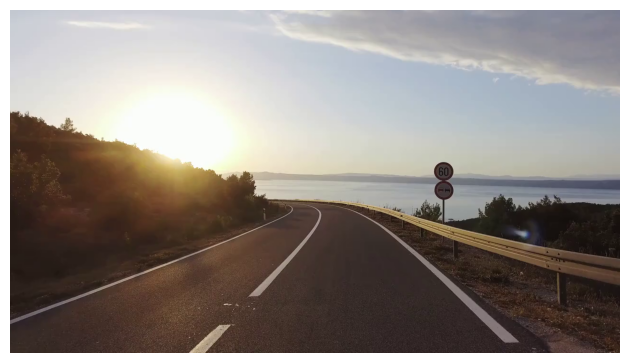

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIG ---
image_path = "./data/yolo/frames/frame0001.png"
model_path = "./models/yolov1_epoch49.pth"  # your trained checkpoint
class_names_path = "./data/yolo/classes.names"
S, B, C = 7, 2, 20# update class count if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conf_threshold = 0.2

# --- Load Class Names ---
with open(class_names_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# --- Load Model ---

model = YOLOv1(S=S, B=B, C=C).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Image Transform ---
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

# --- Load and preprocess image ---
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 448, 448]

# --- Run model ---
with torch.no_grad():
    predictions = model(input_tensor)  # → [1, 7, 7, 30/43 etc]
    print(f"preductions: {predictions.shape}")

output = predictions.squeeze(0).cpu()  # → [7, 7, 30]
print(output)

# --- Post-process output ---
boxes = []
for i in range(S):
    for j in range(S):
        cell = output[i, j]
        class_probs = cell[:C]
        best_class = torch.argmax(class_probs).item()
        class_score = class_probs[best_class].item()
        objectness = cell[C]

        if objectness * class_score > conf_threshold:
            bx = (j + cell[C+1].item()) / S
            by = (i + cell[C+2].item()) / S
            bw = cell[C+3].item() / S
            bh = cell[C+4].item() / S
            boxes.append([best_class, objectness * class_score, bx, by, bw, bh])

# --- Draw predictions ---
fig, ax = plt.subplots(1)
ax.imshow(image)

for box in boxes:
    print(f"box:{box}")
    class_id, conf, x, y, w, h = box
    x_px = (x - w/2) * image.width
    y_px = (y - h/2) * image.height
    w_px = w * image.width
    h_px = h * image.height

    rect = patches.Rectangle((x_px, y_px), w_px, h_px,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    label = f"{class_names[class_id]}: {conf:.2f}"
    ax.text(x_px, y_px - 10, label, color='red',
            fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()